In [102]:
import pandas as pd
from sklearn import preprocessing
import numpy as np
from sklearn.model_selection import train_test_split
from collections.abc import Sequence
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()
    if sd is None:
        sd = df[name].std()
    df[name] = (df[name] - mean) / sd
    
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Data Preprocess

In [103]:
#csv to dataframe
df = pd.read_csv('answers.csv')
df.head()

,Unnamed: 0,qid,i,qs,qt,tags,qvc,qac,aid,j,as,at
0,1,563355,62701.0,0,1235000081,"php,error,gd,image-processing",220,2,563372,67183.0,2,1235000501
1,2,563355,62701.0,0,1235000081,"php,error,gd,image-processing",220,2,563374,66554.0,0,1235000551
2,3,563356,15842.0,10,1235000140,"lisp,scheme,subjective,clojure",1047,16,563358,15842.0,3,1235000177
3,4,563356,15842.0,10,1235000140,"lisp,scheme,subjective,clojure",1047,16,563413,893.0,18,1235001545
4,5,563356,15842.0,10,1235000140,"lisp,scheme,subjective,clojure",1047,16,563454,11649.0,4,1235002457


In [104]:
df.drop(['Unnamed: 0', 'i', 'aid', 'j', 'qac', 'as'], axis=1, inplace=True)
df.head()

,qid,qs,qt,tags,qvc,at
0,563355,0,1235000081,"php,error,gd,image-processing",220,1235000501
1,563355,0,1235000081,"php,error,gd,image-processing",220,1235000551
2,563356,10,1235000140,"lisp,scheme,subjective,clojure",1047,1235000177
3,563356,10,1235000140,"lisp,scheme,subjective,clojure",1047,1235001545
4,563356,10,1235000140,"lisp,scheme,subjective,clojure",1047,1235002457


In [105]:
#group the dataframe by question ID and choose the min value for 'at' column 
df = df.loc[df.groupby('qid').at.idxmin()].reset_index(drop=True)

In [106]:
#obtain the duration of how long each question took
df['duration'] = df['at']-df['qt'] #time that it was asnwered - when it was asked
df.drop(['at', 'qt'], axis = 1, inplace = True)
df['duration'] = df['duration']

In [107]:
df.head()

,qid,qs,tags,qvc,duration
0,563355,0,"php,error,gd,image-processing",220,420
1,563356,10,"lisp,scheme,subjective,clojure",1047,37
2,563365,0,"cocoa-touch,objective-c,design-patterns",108,204
3,563366,0,core-animation,179,2923
4,563367,0,"django,django-models",247,55714


In [108]:
#normalize question score (qs) and qvc (question view)
encode_numeric_zscore(df, 'qs') #question score
encode_numeric_zscore(df, 'qvc') # number of views that question got 
df.head()

,qid,qs,tags,qvc,duration
0,563355,-0.444859,"php,error,gd,image-processing",0.335015,420
1,563356,3.282804,"lisp,scheme,subjective,clojure",4.070681,37
2,563365,-0.444859,"cocoa-touch,objective-c,design-patterns",-0.170904,204
3,563366,-0.444859,core-animation,0.149812,2923
4,563367,-0.444859,"django,django-models",0.456977,55714


In [109]:
# #drop negative durations (questions that have not been answered)
# print("before drop {}" .format(df.shape))
# df = df[df.duration > 0]
# print("after drop {}" .format(df.shape))

In [110]:
#convert duration to hours
df['duration'] = df['duration']/60/60#/60/60 #convert duration from epoch to hours 

In [111]:
df.head()

,qid,qs,tags,qvc,duration
0,563355,-0.444859,"php,error,gd,image-processing",0.335015,0.116667
1,563356,3.282804,"lisp,scheme,subjective,clojure",4.070681,0.010278
2,563365,-0.444859,"cocoa-touch,objective-c,design-patterns",-0.170904,0.056667
3,563366,-0.444859,core-animation,0.149812,0.811944
4,563367,-0.444859,"django,django-models",0.456977,15.476111


In [112]:
df.loc[df['duration'] < 0, 'difficultLevel'] = 'hard' #qquestions that have a negative duration (never got an asnwer) = hard
df.loc[df['duration'] >= 24, 'difficultLevel'] = 'hard' #question that take more than 24 hours to get an answer = hard 
df.loc[df['duration'].between(0, 10, inclusive = True), 'difficultLevel'] = 'easy'#question that between l0 & 10 hours to get an answer = easy 
df.loc[df['duration'].between(10, 24, inclusive = False), 'difficultLevel'] = 'medium'#question that take more between 10, 24 hours to get an answer = medium 

In [113]:
df.head()

,qid,qs,tags,qvc,duration,difficultLevel
0,563355,-0.444859,"php,error,gd,image-processing",0.335015,0.116667,easy
1,563356,3.282804,"lisp,scheme,subjective,clojure",4.070681,0.010278,easy
2,563365,-0.444859,"cocoa-touch,objective-c,design-patterns",-0.170904,0.056667,easy
3,563366,-0.444859,core-animation,0.149812,0.811944,easy
4,563367,-0.444859,"django,django-models",0.456977,15.476111,medium


In [114]:
#get rid of commas in the tags column
df.replace(',',' ', regex=True, inplace=True)
#drop question Id and duration 
df.drop(['qid', 'duration'], axis=1, inplace=True)

In [115]:

df.head()

,qs,tags,qvc,difficultLevel
0,-0.444859,php error gd image-processing,0.335015,easy
1,3.282804,lisp scheme subjective clojure,4.070681,easy
2,-0.444859,cocoa-touch objective-c design-patterns,-0.170904,easy
3,-0.444859,core-animation,0.149812,easy
4,-0.444859,django django-models,0.456977,medium


In [116]:
df = df.assign(tags=df['tags'].str.split(' ')).explode('tags')

In [117]:
df.head()

,qs,tags,qvc,difficultLevel
0,-0.444859,php,0.335015,easy
0,-0.444859,error,0.335015,easy
0,-0.444859,gd,0.335015,easy
0,-0.444859,image-processing,0.335015,easy
1,3.282804,lisp,4.070681,easy


In [118]:
#one hot encode tag column
df = pd.get_dummies(df, columns = ['tags'], prefix="tag")
df.head()

,qs,qvc,difficultLevel,tag_100-continue,tag_10g,tag_11g,tag_12,tag_128-bit,tag_12bit,tag_141,...,tag_ûnet3û5,tag_ûnet3û5sp1,tag_ûnet4û0,tag_ûnet4û1,tag_ûnetcart,tag_ûnetremoting,tag_ûnettiers,tag_ûprofile,tag_ûrefresh,tag_ûwsc
0,-0.444859,0.335015,easy,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,-0.444859,0.335015,easy,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,-0.444859,0.335015,easy,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,-0.444859,0.335015,easy,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3.282804,4.070681,easy,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [119]:
#label encode difficulty column
species = encode_text_index(df,"difficultLevel")

In [120]:
df.head()

,qs,qvc,difficultLevel,tag_100-continue,tag_10g,tag_11g,tag_12,tag_128-bit,tag_12bit,tag_141,...,tag_ûnet3û5,tag_ûnet3û5sp1,tag_ûnet4û0,tag_ûnet4û1,tag_ûnetcart,tag_ûnetremoting,tag_ûnettiers,tag_ûprofile,tag_ûrefresh,tag_ûwsc
0,-0.444859,0.335015,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,-0.444859,0.335015,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,-0.444859,0.335015,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,-0.444859,0.335015,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3.282804,4.070681,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [121]:
#group dataframe row by qs, svc, difficultLvl columns and max value of the rest of the column(tags)
df = df.groupby(['qs', 'qvc', 'difficultLevel']).max().reset_index()
df.head()

,qs,qvc,difficultLevel,tag_100-continue,tag_10g,tag_11g,tag_12,tag_128-bit,tag_12bit,tag_141,...,tag_ûnet3û5,tag_ûnet3û5sp1,tag_ûnet4û0,tag_ûnet4û1,tag_ûnetcart,tag_ûnetremoting,tag_ûnettiers,tag_ûprofile,tag_ûrefresh,tag_ûwsc
0,-12.373383,1.075824,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-6.036355,0.100124,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-6.036355,1.382989,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-4.918056,-0.035390,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-4.918056,1.346852,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Fully Connected Neural Network (FNN)

In [122]:
x,y = to_xy(df,"difficultLevel")

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=69)

In [123]:
#checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=0, save_best_only=True) # save best model

activations = ['relu', 'sigmoid','tanh']
optimizers = ['adam', 'sgd']
numOfLayers = [1, 2]
n1 = [32, 64]
batch_size = 64

best_model = (float('inf'), None)
ind = 0;
# go through all possible configurations
for activation in activations:
    for optimizer in optimizers:
        for neuron in n1:
            for n in numOfLayers:
                #define model
                model = Sequential()
                #input layer
                model.add(Dense(neuron, input_dim=x.shape[1], activation=activation)) 

                #hidden layers
                for i in range(n):
                    model.add(Dense(neuron, activation=activation))

                #output layer
                model.add(Dense(y.shape[1], activation="softmax"))

                model.compile(
                    loss='categorical_crossentropy', 
                    optimizer=optimizer
                )

                monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
                model.fit(
                    x_train,
                    y_train, 
                    validation_data=(x_test,y_test),
                    batch_size = batch_size,
                    callbacks=[monitor],
                    verbose=0,
                    epochs=1000
                )

                pred = model.predict(x_test)
                #pred = np.argmax(pred,axis=1)
                y_true= np.argmax(y_test,axis=1) 
                score = metrics.log_loss(y_true, pred)

                print('activation:{} optimizer:{} hidden layers:{} neurons:{} (log loss:{})'.format(activation, optimizer, n, neuron, score))

                # set new best model manually
                if score < best_model[0]:
                    best_model = (score, model)

                ind += 1
    
print('Training finished...Loading the best model')  
print()

# take best model
model = best_model[1]

Epoch 00008: early stopping
activation:relu optimizer:adam hidden layers:1 neurons:32 (log loss:0.6903227726829271)
Epoch 00007: early stopping
activation:relu optimizer:adam hidden layers:2 neurons:32 (log loss:0.8106022031328729)
Epoch 00007: early stopping
activation:relu optimizer:adam hidden layers:1 neurons:64 (log loss:0.7367239789830455)
Epoch 00007: early stopping
activation:relu optimizer:adam hidden layers:2 neurons:64 (log loss:0.8643619802275241)
Epoch 00059: early stopping
activation:relu optimizer:sgd hidden layers:1 neurons:32 (log loss:0.3332929872649569)
Epoch 00043: early stopping
activation:relu optimizer:sgd hidden layers:2 neurons:32 (log loss:0.3278104992591186)
Epoch 00060: early stopping
activation:relu optimizer:sgd hidden layers:1 neurons:64 (log loss:0.3285579032397954)
Epoch 00045: early stopping
activation:relu optimizer:sgd hidden layers:2 neurons:64 (log loss:0.3321896923068379)
Epoch 00015: early stopping
activation:sigmoid optimizer:adam hidden layers:

# Hyperparameter performances

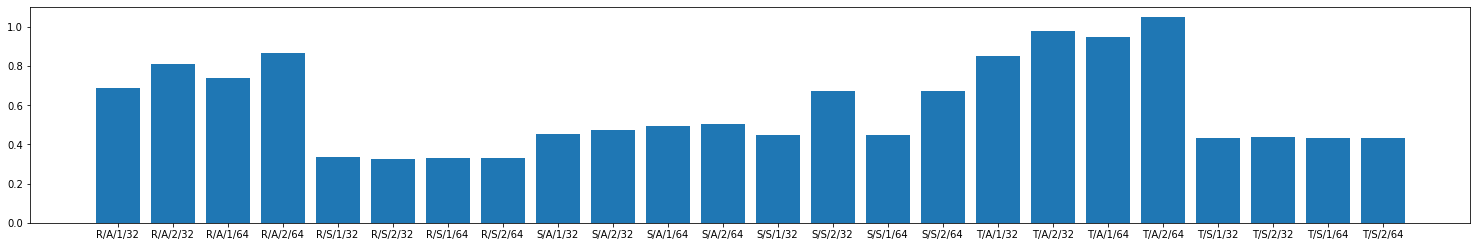

In [8]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.rcParams["figure.figsize"] = (20,20)
ax = fig.add_axes([0,0,1,1])
langs = ['R/A/1/32', 'R/A/2/32', 'R/A/1/64', 'R/A/2/64', 
         'R/S/1/32', 'R/S/2/32', 'R/S/1/64', 'R/S/2/64',
         'S/A/1/32', 'S/A/2/32', 'S/A/1/64', 'S/A/2/64',
         'S/S/1/32', 'S/S/2/32', 'S/S/1/64', 'S/S/2/64',
         'T/A/1/32', 'T/A/2/32', 'T/A/1/64', 'T/A/2/64',
         'T/S/1/32', 'T/S/2/32', 'T/S/1/64', 'T/S/2/64',]

students = [0.6903227726829271,0.8106022031328729,0.7367239789830455,0.8643619802275241,
           0.3332929872649569,0.3278104992591186,0.3285579032397954, 0.3321896923068379, 
           0.4537427383472493, 0.4729918874290993, 0.49245909763815143, 0.5063712116446021, 
           0.44620076529252456, 0.6725537843126759, 0.44823246892641366,0.6722073451720839, 
           0.8497623509407872, 0.9772685229373497, 0.9473308220734888, 1.0499600516024303, 
          0.43261811909384396, 0.435554931084125, 0.43301191296873215, 0.43284886150593144]
ax.bar(langs,students)
plt.show()

# FNN: Recall, precision, & F1 score

In [124]:
#print best model
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_true= np.argmax(y_test,axis=1) 

#recall score
score = metrics.recall_score(y_true, pred, average= "weighted")
print("Recall score: {}".format(score))
#precision score
score = metrics.precision_score(y_true, pred, average= "weighted")
print("Precision score: {}".format(score))
#F1 score
score = metrics.f1_score(y_true, pred, average= "weighted")
print("F1 score: {}".format(score))

Recall score: 0.8599520383693046
Precision score: 0.8013746005180084
F1 score: 0.8271103598097209


/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# FNN: Confusion Matrix

              precision    recall  f1-score   support

           0       0.95      0.98      0.96      1632
           1       0.49      0.74      0.59       258
           2       0.00      0.00      0.00       195

    accuracy                           0.86      2085
   macro avg       0.48      0.58      0.52      2085
weighted avg       0.80      0.86      0.83      2085



/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


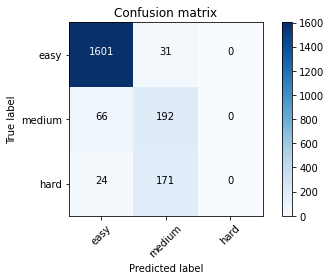

In [125]:
cnf_matrix = confusion_matrix(y_true, pred,labels=[0,1,2])
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['easy', 'medium', 'hard'],
                      title='Confusion matrix')
print(classification_report(y_true, pred))

# Convolutional Neural Networks (CNN) Model

In [126]:
x = df.drop('difficultLevel', axis = 1, inplace = False)
y = df.difficultLevel

print(x.shape)
print(y.shape)

(8340, 14250)
(8340,)


In [127]:
x = x.to_numpy()
x = x.reshape((8340, 1, 14250, 1))

y = y.to_numpy()
y = tf.keras.utils.to_categorical(y,3)

In [128]:
# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=77) 
print(x_train.shape)
print(y_train.shape)

(6255, 1, 14250, 1)
(6255, 3)


In [129]:
#checkpointer = ModelCheckpoint(filepath="dnn/best_weights_cnn.hdf5", verbose=0, save_best_only=True) # save best model

activations = ['relu', 'sigmoid','tanh']
optimizers = ['adam', 'sgd']
batch_size = 64
n1 = [32]
kernelNum = [2]
kernelSize = [[1, 2]]
best_model = (float('inf'), None)

# go through all possible configurations
for activation in activations:
    for optimizer in optimizers:
        for neuron in n1:
            for k in kernelNum:
                for ks in kernelSize:
                    # define a CNN
                    cnn = Sequential()
                    cnn.add(Conv2D(neuron, kernel_size=(ks[0], ks[1]), strides=(1, 1), activation=activation, input_shape=(1, 14250, 1)))
                    cnn.add(MaxPooling2D(pool_size=(1,2)))

                    #conv layers
                    for i in range(k):
                        cnn.add(Conv2D(neuron, kernel_size=(ks[0], ks[1]), strides=(1, 1), activation=activation))
                        cnn.add(MaxPooling2D(pool_size=(1,2)))

                    cnn.add(Flatten())

                    #fully connected layers
                    for j in range(k):
                        cnn.add(Dense(neuron, activation=activation))
                        cnn.add(Dropout(0.5))

                    #output layer
                    cnn.add(Dense(3, activation="softmax"))

                    # define optimizer and objective, compile cnn
                    cnn.compile(
                            loss="categorical_crossentropy", 
                            optimizer=optimizer)

                    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')

                    cnn.fit(x_train,
                            y_train, 
                            validation_data=(x_test,y_test),
                            batch_size = batch_size,
                            callbacks=[monitor],
                            verbose=0,
                            epochs=1000
                       )

                    pred = cnn.predict(x_test)
                    #pred = np.argmax(pred,axis=1)
                    y_true= np.argmax(y_test,axis=1) 
                    score = metrics.log_loss(y_true, pred)

                    print('activation:{} optimizer:{} kernel size:{} kernel num: {} neurons:{} (log loss:{})'.format(activation, optimizer, ks, k, neuron, score))

                    # set new best model manually
                    if score < best_model[0]:
                        best_model = (score, cnn)
    
print('Training finished...Loading the best model')  
print()

# take best model
model = best_model[1]

Epoch 00010: early stopping
activation:relu optimizer:adam kernel size:[1, 2] kernel num: 2 neurons:32 (log loss:0.4398036015815504)
Epoch 00047: early stopping
activation:relu optimizer:sgd kernel size:[1, 2] kernel num: 2 neurons:32 (log loss:0.33145396597804166)
Epoch 00010: early stopping
activation:sigmoid optimizer:adam kernel size:[1, 2] kernel num: 2 neurons:32 (log loss:0.6718876343908355)
Epoch 00006: early stopping
activation:sigmoid optimizer:sgd kernel size:[1, 2] kernel num: 2 neurons:32 (log loss:0.6723353898782525)
Epoch 00009: early stopping
activation:tanh optimizer:adam kernel size:[1, 2] kernel num: 2 neurons:32 (log loss:0.5446743369584471)
Epoch 00036: early stopping
activation:tanh optimizer:sgd kernel size:[1, 2] kernel num: 2 neurons:32 (log loss:0.3186284464633396)
Training finished...Loading the best model



# Hyperparameter performances

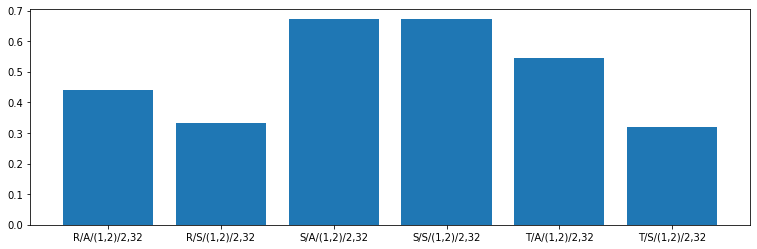

In [19]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.rcParams["figure.figsize"] = (10,7)
ax = fig.add_axes([0,0,1,1])
langs = ['R/A/(1,2)/2,32',  
         'R/S/(1,2)/2,32', 
         'S/A/(1,2)/2,32',
         'S/S/(1,2)/2,32',
         'T/A/(1,2)/2,32',
         'T/S/(1,2)/2,32']

students = [0.4398036015815504,
           0.33145396597804166,
           0.6718876343908355,
           0.6723353898782525,
           0.5446743369584471,
           0.3186284464633396]
ax.bar(langs,students)
plt.show()

# CNN: Recall, precision and F1-score

In [130]:
#print best model
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_true= np.argmax(y_test,axis=1) 

#recall score
score = metrics.recall_score(y_true, pred, average= "weighted")
print("Recall score: {}".format(score))
#precision score
score = metrics.precision_score(y_true, pred, average= "weighted")
print("Precision score: {}".format(score))
#F1 score
score = metrics.f1_score(y_true, pred, average= "weighted")
print("F1 score: {}".format(score))

Recall score: 0.8633093525179856
Precision score: 0.8545101249717508
F1 score: 0.8438370485380965


# CNN: Confusion matrix

              precision    recall  f1-score   support

           0       0.95      0.98      0.96      1631
           1       0.51      0.70      0.59       267
           2       0.54      0.11      0.18       187

    accuracy                           0.86      2085
   macro avg       0.67      0.59      0.58      2085
weighted avg       0.85      0.86      0.84      2085



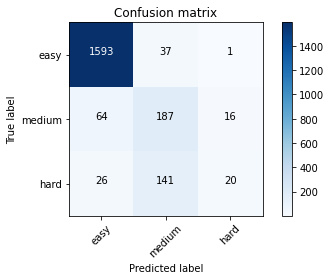

In [131]:
cnf_matrix = confusion_matrix(y_true, pred,labels=[0,1,2])
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['easy', 'medium', 'hard'],
                      title='Confusion matrix')
print(classification_report(y_true, pred))

# FNN VS CNN

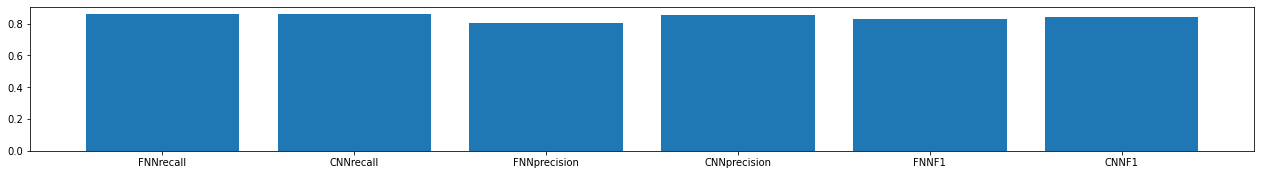

In [51]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.rcParams["figure.figsize"] = (17,2)
ax = fig.add_axes([0,0,1,1])
metrics = ['FNNrecall', 'CNNrecall',
         'FNNprecision', 'CNNprecision',
         'FNNF1','CNNF1']

vals = [0.8599520383693046,0.8633093525179856,
           0.8013746005180084,0.8545101249717508,
           0.8271103598097209,0.8438370485380965]
ax.bar(metrics,vals)
plt.show()